Find design variables $x$ = ($D_{body}$,$D_{tank}$,$L_{body}$,$L_{oxtank}$,$L_{fueltank}$) to

Minimize:

$\Delta$$v$($x$) = $-$$I_{sp}$$g_o$$ln$($\frac{m_0}{m_f}$)

s.t. 1 equality constraint

$\frac{m_{ox}}{m_{fuel}}$ $-$ $2.5$ = $0$

And 4 inequality constraints

$\frac{T}{m_0g_0}$ $-$ $ 3 > 0$

$D_{body}$ - ($D_{tank}$ + $body tank gap$) $> 0$

$L_{body} - L_{ox} - L_{fuel} - 2D_{tank} - additional space > 0$

$\frac{L_{body}}{D_{body}}$ $-$ $4 > 0$

with bounds:

$0 < D_{body} < 3$

$0 < D_{tank} < 3$

$0 < L_{body} < 24$

$0 < L_{oxtank} < 24$

$0 < L_{fueltank} < 24$

In [1]:
# Importing various libraries

import numpy as np
from scipy.optimize import minimize
from math import exp
# Definition of parameters
pi = np.pi
rho_al = 2700 # [kg/m**3]
rho_ox = 1141 # [kg/m**3]
rho_fuel = 804 # [kg/m**3]
m_payload = 10.0 # [kg]
m_engine = 15.0 # [kg]
P_op = 2.5 # [MPa]
sigma_al = 240 # [MPa]
I_sp = 250 # [s]
g_0 = 9.81 # [m/s**2]
T = 10000 # [N]
body_tank_gap = 0.2 # [m]
additional_space = 0.5 # [m]
# Initial design variables 

x0 = np.array([0.5, 0.5, 4, 1, 1]) # (D_body,D_tank,L_body,L_oxtank,L_fueltank)

# Function to calculate the intial and final mass of the rocket

def m0_and_mf(x):
    m_body = 0.002*pi*rho_al*x[0]*x[2]
    m_fairing = (0.002*pi*rho_al*x[0])/(75*x[0]**2)*(101/8*101**0.5*x[0]**3)
    m_ox = rho_ox * (pi/6 * x[1]**3 + pi/4 * x[0]**2 * x[3])
    m_fuel = rho_fuel*(pi/6*x[1]**3+pi/4*x[0]**2*x[4])
    m_oxtank = (pi*rho_ox*x[1]**2*P_op)/(4*sigma_al)*(x[3] + 1/(3**0.5))
    m_fueltank = (pi*rho_fuel*x[1]**2*P_op)/(4*sigma_al)*(x[4] + 1/(3**0.5))
    m_0 = m_payload+m_engine+m_body+m_fairing+m_ox+m_fuel+m_oxtank+m_fueltank
    m_f = m_0-m_ox-m_fuel   

    return m_0, m_f

# Definition of the objective function
                                                     
def objective(x):
    m_0, m_f = m0_and_mf(x)
    return -I_sp*g_0*np.log(m_0/m_f)

# Definition of equality constraint

def constraint1(x):
    m_ox = rho_ox * (pi/6 * x[1]**3 + pi/4 * x[0]**2 * x[3])
    m_fuel = rho_fuel*(pi/6*x[1]**3+pi/4*x[0]**2*x[4])
    return m_ox/m_fuel - 2.5

def constraint2(x):
    m_0, m_f = m0_and_mf(x)
    return T/(m_0 * g_0 + 1e-09 ) - 3

# Definition of inequality constraints

def constraint3(x):
    return x[0] - (x[1] + body_tank_gap)

def constraint4(x):
    return x[2] - x[3] - x[4] - additional_space - 2*x[1]

def constraint5(x):
    return x[2]/x[0] - 4

# Definition of bounds on design varibles

d_bnds = (0.25,4.0)
L_bnds = (0.25,32.0)
bnds = (d_bnds,d_bnds,L_bnds,L_bnds,L_bnds)

# Conversion of constraints into a form accepted by the "minimize" function

con1 = {'type': 'eq','fun': constraint1}
con2 = {'type': 'ineq', 'fun': constraint2}
con3 = {'type': 'ineq', 'fun': constraint3}
con4 = {'type': 'ineq', 'fun': constraint4}
con5 = {'type': 'ineq', 'fun': constraint5}
cons = [con1, con2, con3, con4, con5]


In [2]:
# Solver setup

sol = minimize(objective,x0,method='SLSQP',bounds=bnds,constraints=cons, tol='1e-09')
options = {'ftol': 1e-09, 'eps': 1e-09}

print(sol)

     fun: -4573.848745853717
     jac: array([-5901.01245117,  -922.61724854,   300.61553955, -1286.81018066,
        -906.74456787])
 message: 'Positive directional derivative for linesearch'
    nfev: 42
     nit: 11
    njev: 7
  status: 8
 success: False
       x: array([0.45      , 0.25000001, 2.6690286 , 1.0788477 , 0.59018088])


In [3]:
# Post-processing optimization results into usable data

delta_v = -1 * sol.fun
m_0, m_f = m0_and_mf(sol.x)
mass_ox = rho_ox * (pi/6 * sol.x[1]**3 + pi/4 * sol.x[0]**2 * sol.x[3])
mass_fuel = rho_fuel*(pi/6*sol.x[1]**3+pi/4*sol.x[0]**2*sol.x[4])
burn_time = m_0*I_sp*g_0*(1-exp(-delta_v/(I_sp*g_0)))/T

# Print out results

print('Maximum Delta-V: {} m/s'.format(delta_v))
print('Body Diameter: {} m'.format(sol.x[0]))
print('Tank Diameter: {} m'.format(sol.x[1]))
print('Nosecone Length: {} m'.format(sol.x[0]*2.5))
print('Body Length: {} m'.format(sol.x[2]))
print('Oxygen Tank Cylinder Length: {} m'.format(sol.x[3]))
print('Fuel Tank Cylinder Length: {} m'.format(sol.x[4]))
print('Mass of Oxygen: {} kg'.format(mass_ox))
print('Mass of Kerosene: {} kg'.format(mass_fuel))
print('Initial Mass: {} kg'.format(m_0))
print('Final Mass: {} kg'.format(m_f))
print('Burn time: {} s'.format(burn_time))


Maximum Delta-V: 4573.848745853717 m/s
Body Diameter: 0.4499999972566612 m
Tank Diameter: 0.25000001457397325 m
Nosecone Length: 1.124999993141653 m
Body Length: 2.6690285959262425 m
Oxygen Tank Cylinder Length: 1.0788477025898282 m
Fuel Tank Cylinder Length: 0.5901808826921887 m
Mass of Oxygen: 205.1113441995535 kg
Mass of Kerosene: 82.04453768043456 kg
Initial Mass: 339.7893293790561 kg
Final Mass: 52.63344749906801 kg
Burn time: 70.42498003106708 s


The solver successfully reached the end of the integration interval.
True


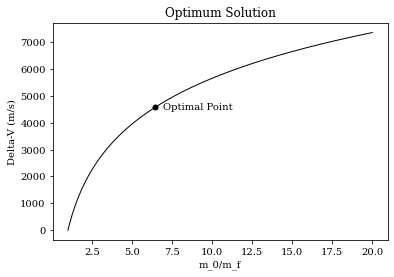

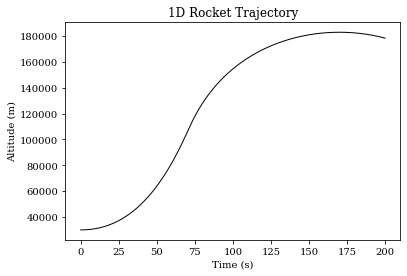

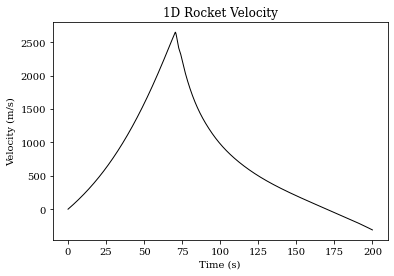

Predicted Apogee: 178312.6011756544 m


In [11]:
from scipy.integrate import solve_ivp

# Definition of parameters

C_d = 0.5
# rho_a = 1.204 # [kg/m**3]
rho_a = 0.01841 # [kg/m**3] if launched from 30 km
A_ref = sol.x[0]**2 # [m**2]
sim_time = 200 # [s]
sim_int = int((sim_time + 1) / 0.01)
def f(t, y):
    
    rocket_velocity = y[0]
    rocket_altitude = y[1]
    
    if (t <= burn_time):
        T = 10000
        rocket_mass = m_0 - T/(I_sp*g_0)*t
    else:
        T = 0
        rocket_mass = m_f
    
    dvdt = ((T-rocket_mass*g_0-0.5*C_d*rho_a*A_ref*rocket_velocity**2)/rocket_mass)
    dxdt = rocket_velocity
    
    return np.array([dvdt, dxdt])

# Solve 1D rigid body motion equation for rocket using RK45 ODE method

y0 = np.array([0, 30000])
t_span = np.array([0, sim_time])
times = np.linspace(t_span[0], t_span[1], sim_int)
soln = solve_ivp(f, t_span, y0, t_eval=times)
t = soln.t
rocket_velocity = soln.y[0]
rocket_altitude = soln.y[1]
print(soln.message)
print(soln.success)

# Visualize the solution

import matplotlib.pyplot as plt

# Delta-V vs. m0/mf plot

m_frac = np.linspace(1, 20, 210)
del_v = I_sp*g_0*np.log(m_frac)
plt.rcParams["font.family"] = "serif"
plt.plot(m_frac,del_v, 'k-', linewidth=1)
plt.plot(m_0/m_f,delta_v,"ko", markersize=5)
plt.annotate('Optimal Point',(m_0/m_f + 0.5,delta_v - 100))
plt.xlabel('m_0/m_f')
plt.ylabel('Delta-V (m/s)')
plt.title('Optimum Solution')
plt.savefig('opt_sol_plt.png', bbox_inches='tight', transparent=True)
plt.show()

# Altitude plot

plt.plot(t, rocket_altitude, 'k-', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title('1D Rocket Trajectory')
plt.savefig('opt_alt_plt.png', bbox_inches='tight', transparent=True)
plt.show()

# Velocity plot

plt.plot(t, rocket_velocity, 'k-', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('1D Rocket Velocity')
plt.savefig('vel_plt.png', bbox_inches='tight', transparent=True)
plt.show()
# Find the apogee

apogee = np.interp(0,soln.y[0],soln.y[1])
print('Predicted Apogee: {} m'.format(apogee))